In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ОПИСАНИЕ ПРОЕКТА

ЗАДАЧА: Построить модель, которая предсказывает вероятность дефолта клиента банка.

ЭТАПЫ РАБОТЫ:

1. первичная визуализация - выводы о качестве данных, распр-е целевой переменной;
2. построение наивной модели + метрики;
3. EDA: визуализация, выбросы, пропуски, корреляционный анализ, генерация признаков; 
4. оценка важности;
5. построение модели логистической регрессии;
6. подбор гиперпараметров;
7. эксперименты с другими моделями, определение лучшей.
8. финальная модель, submission. 

ОПИСАНИЯ ПОЛЕЙ:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов клиента в БКИ о своей кредитной истории
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

# Используемые библиотеки

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline



Bad key "text.kerning_factor" on line 4 in
C:\Users\lll20\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Вспомогательные функции

In [3]:
def visualise_metrics(model, X, y):
    # разделение выборки на train и valid
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=RANDOM_SEED, test_size=0.2)

    # Обучение модели на тренировочных данных и получение предсказания на валидационных
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    # вывод типа модели
    print()
    print('Model Type: ' + str(model))
    print()

    # вывод confusion matrix:
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True\nPositive', 'False\nPositive',
                   'False\nNegative', 'True\nNegative']
    group_counts = ['{0:0.0f}'.format(
        value) for value in confusion_matrix(y_valid, y_pred).flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_valid, y_pred),
                     annot=labels, fmt='', cmap='Reds')
    ax.set(xlabel='predicted', ylabel='real', title='Confusion Matrix')
    plt.show()
    print()

    # вывод значений метрик:
    print('accuracy_score:\t\t {:.3}'.format(accuracy_score(y_valid, y_pred)))
    print('f1_score:\t\t {:.3}'.format(f1_score(y_valid, y_pred)))
    print('precision_score:\t {:.3}'.format(precision_score(y_valid, y_pred)))
    print('recall_score:\t\t {:.3}'.format(recall_score(y_valid, y_pred)))
    print('roc_auc_score:\t\t {:.3}'.format(roc_auc_score(y_valid, probs)))
    print()


In [4]:
RANDOM_SEED=42

In [5]:
#Для kaggle вводим это
'''data = pd.read_csv("/kaggle/input/sf-dst-scoring/train.csv")
test_data = pd.read_csv("/kaggle/input/sf-dst-scoring/test.csv")
sample=pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')'''

In [5]:
#Для своего комп вводим это
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


In [6]:
# Для корректной обработки обьеденяем данные
data['sample'] = 1 
test_data['sample'] = 0 
test_data['default'] = -1 

df = test_data.append(data, sort=False).reset_index(drop=True)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


# 1. Первичная визуализация

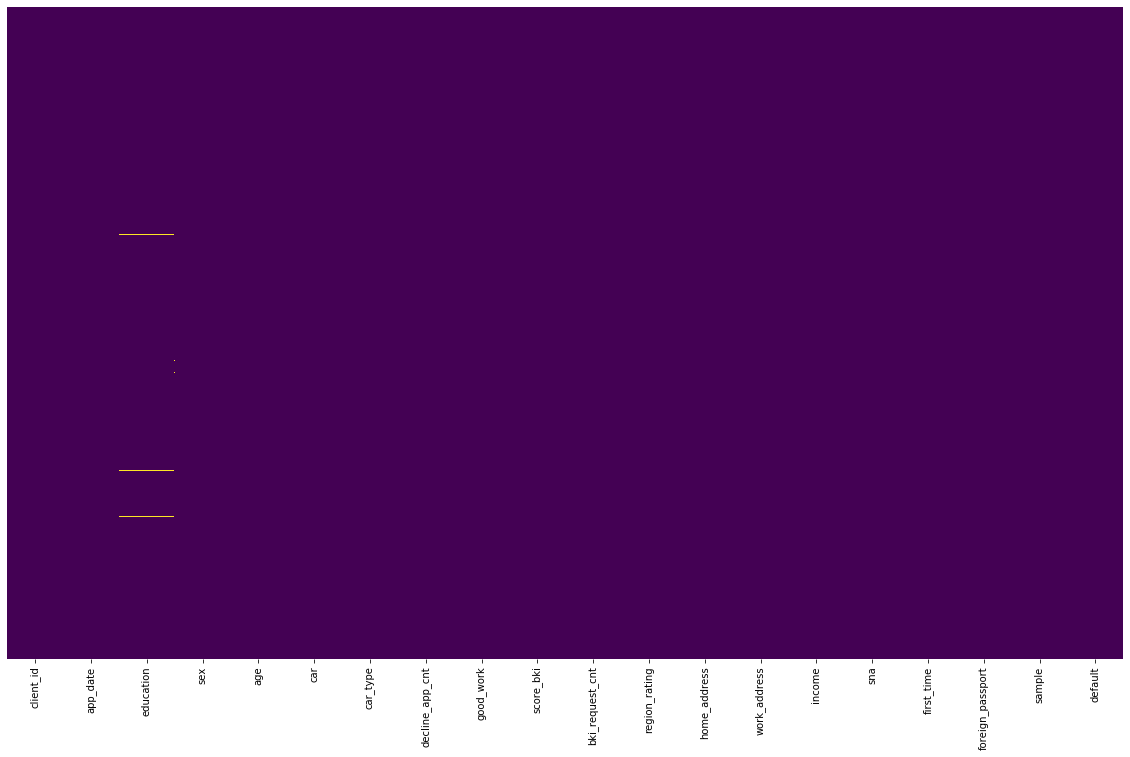

In [7]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных. Пропуски имеются только в одном столбце 'education'.

Посмотрим на распределение признака default:

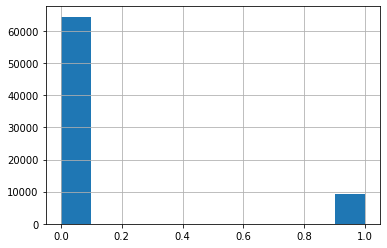

In [8]:
data.default.hist()

Недефолтных клиентов у банка значительно больше, чем дефолтных. Данные несбалансированны.

Сгруппируем признаки в три категории по типу их обработки (категориальные, бинарные и числовые):

In [9]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'app_date']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating','first_time']

Смотрим распределение числовых признаков:

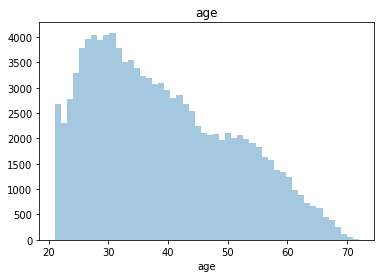

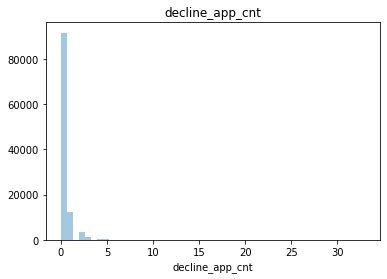

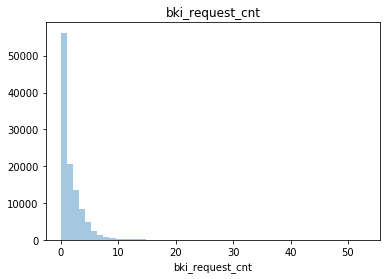

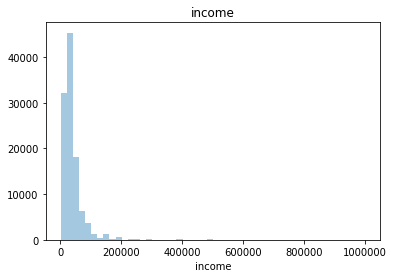

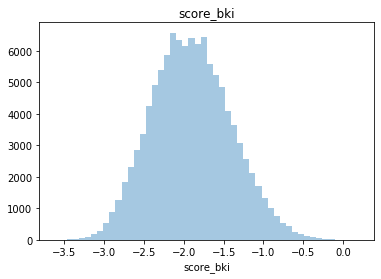

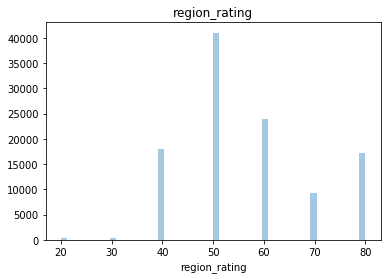

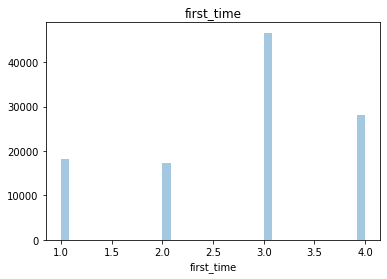

In [10]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

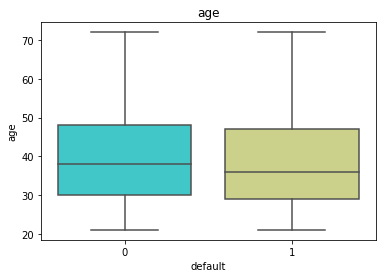

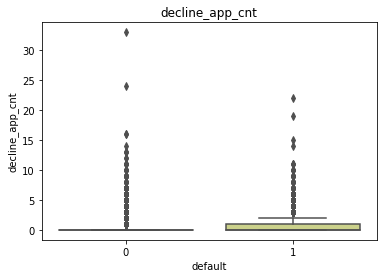

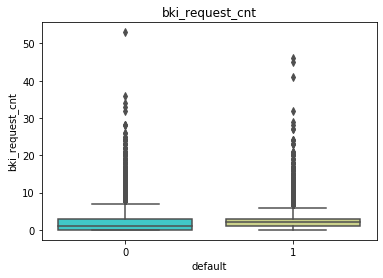

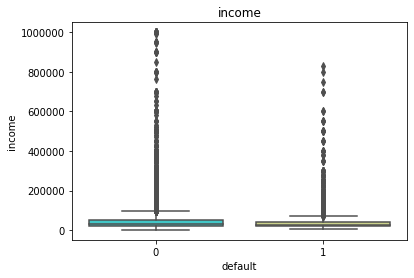

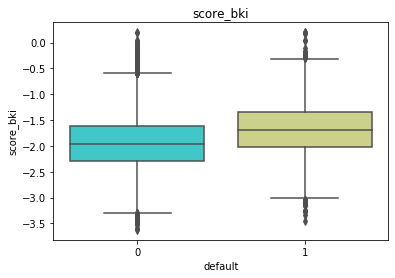

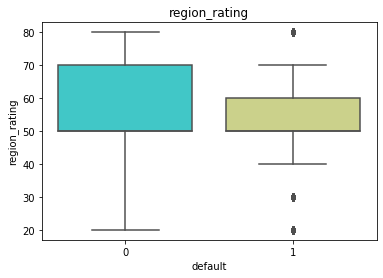

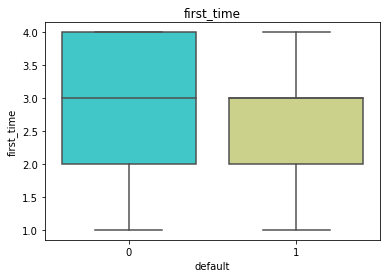

In [11]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = data[i], data = data,  palette='rainbow')
    plt.title(i)
    plt.show()

* Видим, что распределения всех чиловых признаков, кроме score_bki, имеют тяжелый правый хвост.
*  Дефолтные клиенты в среднем младше, имеют большее количество отклоненных заявок и больше запрсов в БКИ,а также в среднем имеют более низкий доход.

Оценим корреляцию:

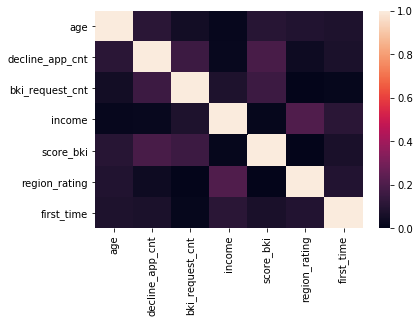

In [12]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

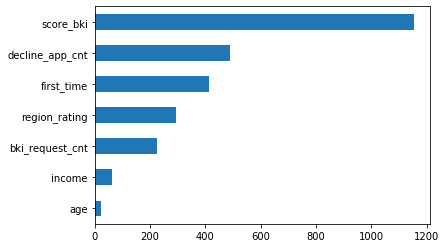

In [13]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Так как категориальные признаки требуют обработки, рассмотрим их подробнее в разделе 3.

# Построение наивной модели

Займемся преобразованием бинарных признаков:

In [14]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [15]:
#удалим "education" из-за наличия пропусков
#удалим "app_date" и 'client_id'
df_naiv = df.drop(['client_id', 'education', 'app_date'], axis =1 )


In [16]:
train_processed = df_naiv.query('sample == 1').drop(['sample'], axis=1)
test_processed = df_naiv.query('sample == 0').drop(['sample'], axis=1)

In [17]:
# удалим для X целевую переменную
X = train_processed.drop(columns=['default'])
y = train_processed['default']


Model Type: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



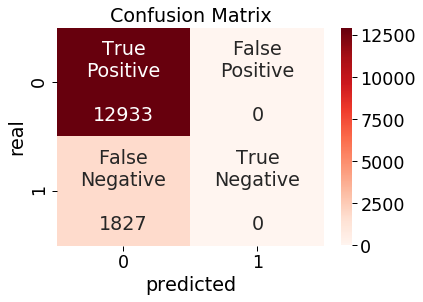


accuracy_score:		 0.876
f1_score:		 0.0
precision_score:	 0.0
recall_score:		 0.0
roc_auc_score:		 0.584



C:\Users\lll20\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)

Наивная модель выдает кредит абсолютно всем и предсказывает отсутствие дефолтных клиентов. Идеально, но несопоставимо с реальностью.

# EDA: визуализация, выбросы, пропуски, корреляционный анализ, генерация признаков

* education

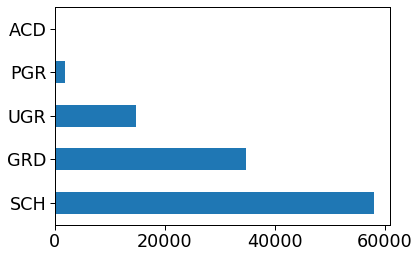

In [19]:
df.education.value_counts().plot.barh()

Заполним пропуски самым распространенным значением - "SCH":

In [20]:
df.education = df.education.fillna(df.education.mode()[0])
df.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

Закодируем  признак education:

In [21]:
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,-1
1,17527,24JAN2014,3,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,-1
2,75683,23MAR2014,4,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,-1
3,26883,03FEB2014,3,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,-1
4,28862,04FEB2014,1,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,-1


* Так как распределения всех чиловых признаков, кроме score_bki, имеют тяжелый правый хвост. Прологарифмируем их,чтобы уйти от этой проблемы. score_bki исключим из логарифмировани, так как он может принимать отрицательные значения.

In [22]:
for i in num_cols:
    if i != 'score_bki':
        df[i] =  np.log(1 + df[i])

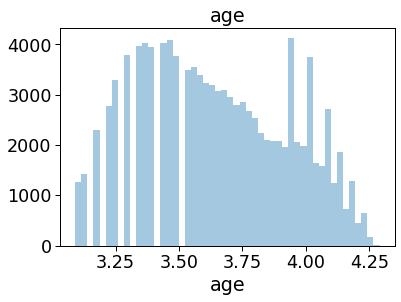

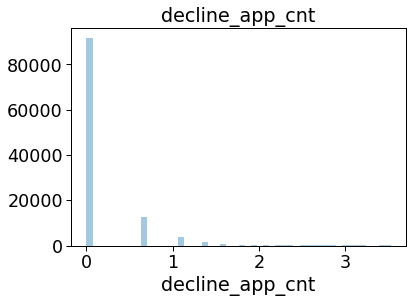

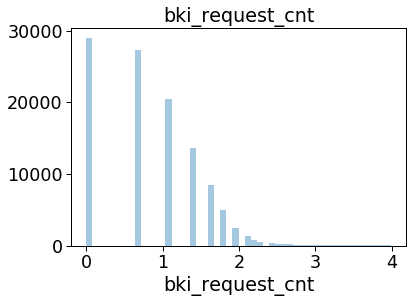

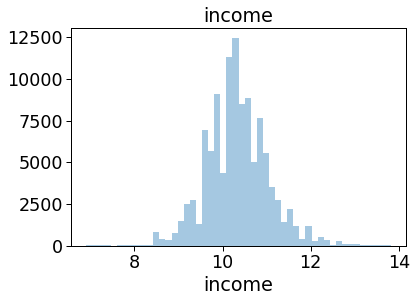

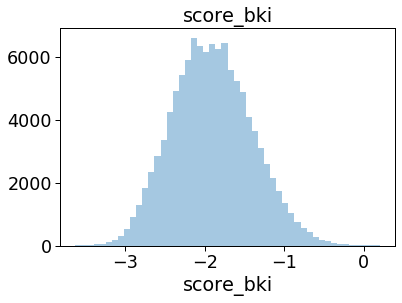

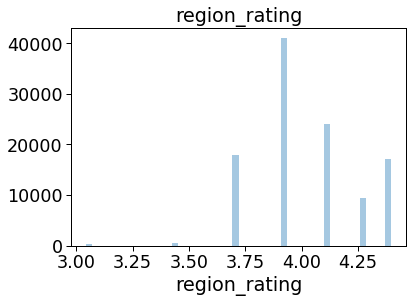

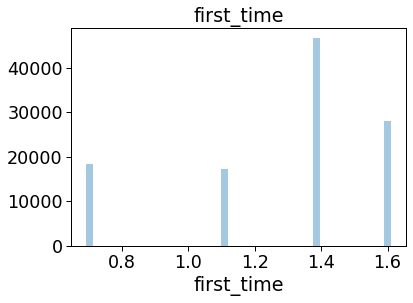

In [23]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

Сработало только с признаком income.

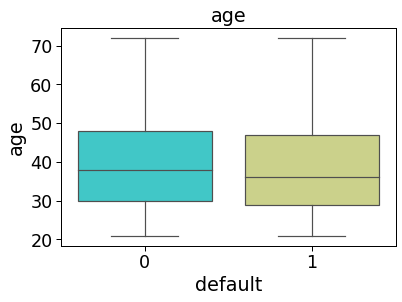

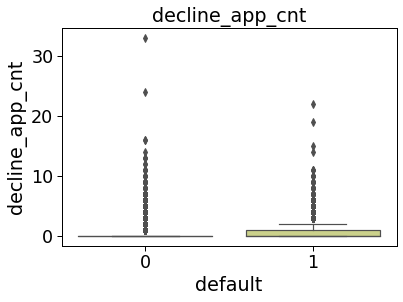

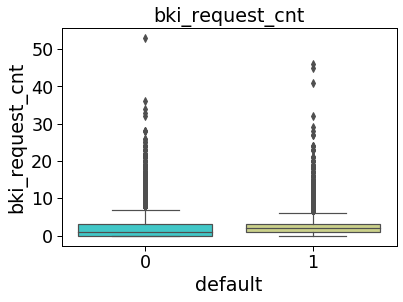

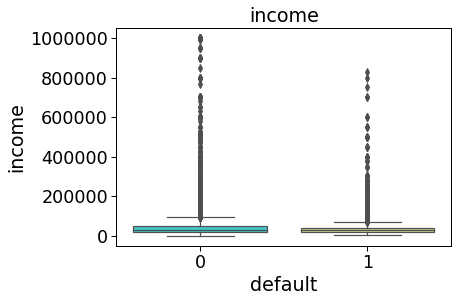

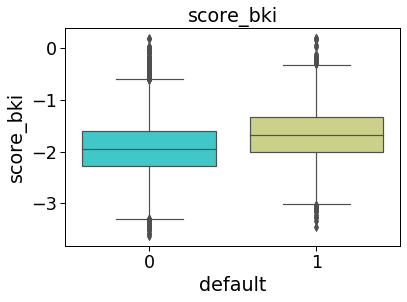

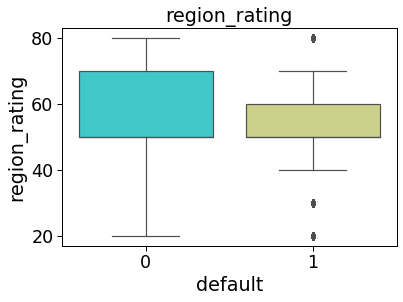

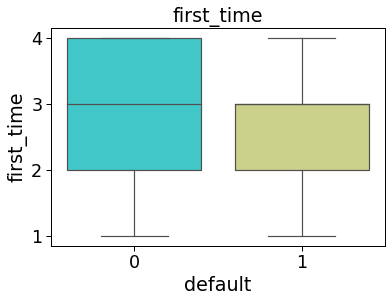

In [24]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = data[i], data = data,  palette='rainbow')
    plt.title(i)
    plt.show()

На боксплотах видно большое количество выбросов в score_bki, income и decline_app_cnt.

* app_date

In [25]:
df['app_date'] = pd.to_datetime(df['app_date'])
df['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

Данные предоставлены всего за 4 месяца. Преобразуем app_date в app_month:

In [26]:
df['app_month'] = df['app_date'].apply(lambda x: x.month)

In [27]:
cat_cols.append('app_month')

In [28]:
cat_cols = list(set(cat_cols) - set(['app_date']))

In [29]:
df = df.drop(df[['app_date']], axis=1)


# Оценка важности

Оценим корреляцию и значимость числовых признаков:

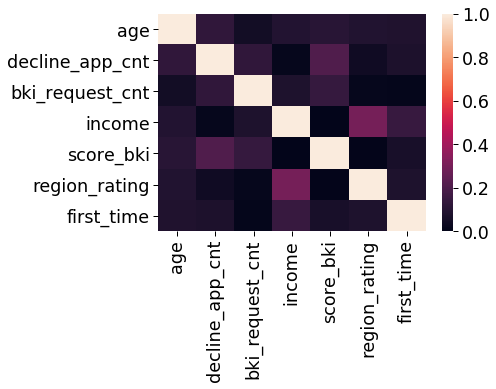

In [30]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

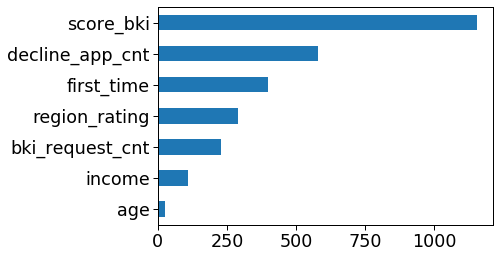

In [31]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Как мы видим, взаимосвязь пар числовых признаков по Пирсону слабая, что прекрасно для нашей модели! 
score_bki - наиболее значимый числовой признак, age - наименее значимый.

Оценим корреляцию и значимость категориальных признаков:

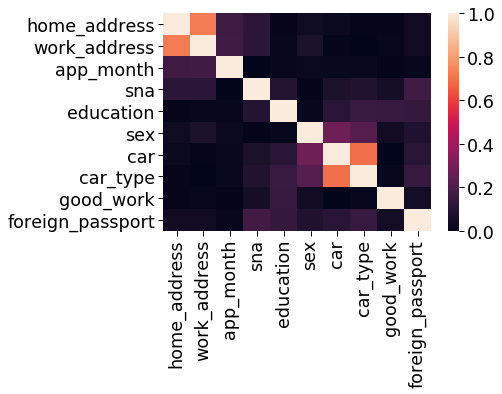

In [32]:
sns.heatmap(df[cat_cols + bin_cols].corr().abs(), vmin=0, vmax=1)

Наблюдается высокая корреляция между признаками home_addres/work_address, car/car_type. Посмотрим на значимость признаков и решим, какие отбросить, а какие оставить.

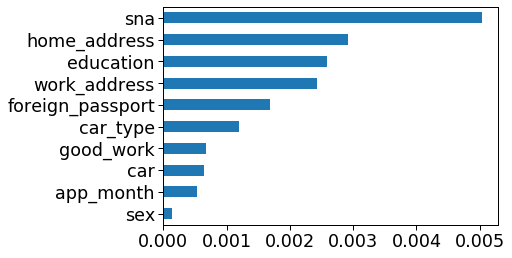

In [33]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Согласно значимости оставляем - home_address и car_type, удаляем - work_address и car. Также удаляем столбец client_id.

In [34]:
df = df.drop(df[['work_address', 'car_type', 'client_id']], axis=1)
cat_cols = list(set(cat_cols) - set(['work_address']))
bin_cols = list(set(bin_cols) - set(['car_type']))

Перед обучением регрессии стандартизируем числовые признаки,а для категориальных переменных используем dummy-кодирование:

In [35]:
X_num = StandardScaler().fit_transform(df[num_cols].values)
df[num_cols]=X_num

In [36]:
df = pd.get_dummies(df, columns=cat_cols)
df.head()

,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,first_time,...,home_address_2,home_address_3,sna_1,sna_2,sna_3,sna_4,app_month_1,app_month_2,app_month_3,app_month_4
0,1,-0.888776,1,-0.418815,0,-0.735587,0.770563,-0.439531,0.680425,1.061008,...,0,0,1,0,0,0,0,0,1,0
1,0,0.120447,0,4.539989,0,0.800039,0.333797,-0.439531,-2.624624,0.336016,...,0,0,0,0,0,1,1,0,0,0
2,1,0.972731,1,-0.418815,0,0.426908,-0.281790,-0.439531,-0.052834,0.336016,...,0,0,1,0,0,0,0,0,1,0
3,1,1.362924,0,-0.418815,0,-0.940432,-0.281790,-1.408242,-0.868125,0.336016,...,0,0,1,0,0,0,0,1,0,0
4,0,0.031629,0,-0.418815,0,-1.167347,-1.334144,1.613807,1.937123,0.336016,...,1,0,1,0,0,0,0,1,0,0


# Построение модели логистической регрессии


Model Type: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



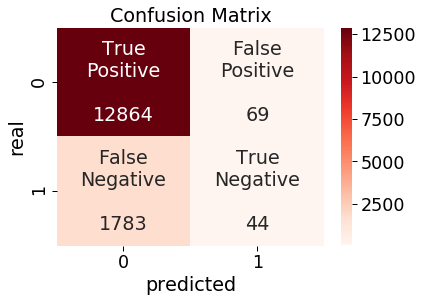


accuracy_score:		 0.875
f1_score:		 0.0454
precision_score:	 0.389
recall_score:		 0.0241
roc_auc_score:		 0.741



In [37]:
train_processed = df.query('sample == 1').drop(['sample'], axis=1)
test_processed = df.query('sample == 0').drop(['sample'], axis=1)

# удалим для X целевую переменную 
X = train_processed.drop(columns=['default'])
y = train_processed['default']

lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)

Предсказания модели улучшились, но всё еще неприменимы в реальной жизни. Улучшаем!

# Эксперименты


Model Type: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



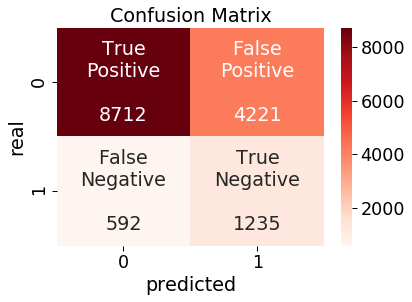


accuracy_score:		 0.674
f1_score:		 0.339
precision_score:	 0.226
recall_score:		 0.676
roc_auc_score:		 0.741



In [38]:
lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

В сбалансированной модели резко уменьшается количество ошибок первого рода, но появляется значительное количество ошибок второго рода.

# Подбор гиперпараметров

In [39]:
# создадим набор гиперпараметров
hyperparameters = {'C': np.logspace(-4, 4, 20)}

X = train_processed.drop(columns=['default'])
y = train_processed['default']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=RANDOM_SEED, test_size=0.2)

model = LogisticRegression(random_state=RANDOM_SEED,
                           class_weight='balanced', max_iter=1000)

# создадим сетку поиска с использованием 5-кратной перекрёстной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring='roc_auc')

best_model = clf.fit(X_train, y_train)

# вывод лучшего параметра С
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее C: 0.012742749857031334



Model Type: LogisticRegression(C=0.012742749857031334, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



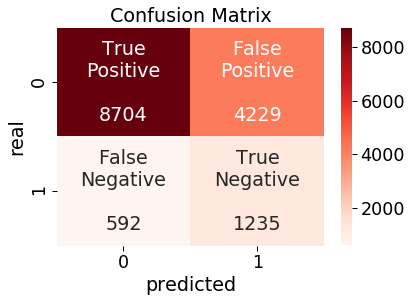


accuracy_score:		 0.673
f1_score:		 0.339
precision_score:	 0.226
recall_score:		 0.676
roc_auc_score:		 0.741



In [40]:
lr_best = LogisticRegression(
    random_state=RANDOM_SEED, class_weight='balanced', max_iter=1000, C= 0.012742749857031334)
visualise_metrics(lr_best, X, y)

Попробуем применить undersampling:


Model Type: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



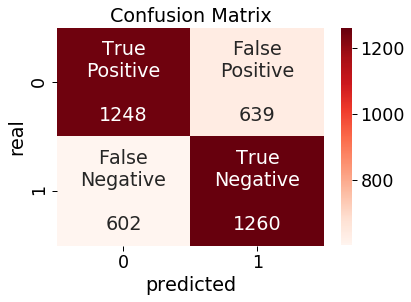


accuracy_score:		 0.669
f1_score:		 0.67
precision_score:	 0.664
recall_score:		 0.677
roc_auc_score:		 0.733



In [41]:

# оставим случайным образом в тренировочных данных столько строк с нулевым дефолтом,
# сколько всего есть данных меньшего класса
train_unders = pd.concat([train_processed[train_processed['default'] == 0].sample(
    len(train_processed[train_processed['default'] == 1]), random_state=RANDOM_SEED),
    train_processed[train_processed['default'] == 1]])

X = train_unders.drop(columns=['default'])
y = train_unders['default']

lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)


Применение undersampling позволило значительно улучшить предсказания модели. Теперь верные предсказания по дефолтным и недефолтным клиентам превосходят ошибочные. Но показатель ROC AUC стал меньше.

# Выводы

* После обработки данных (EDA) построили базовую модель логистической регрессии, которая показала ROC AUC > 0.74, а также accuracy 0.875, precision 0.389, recall 0.024 и f1_score 0.0454
* При подборе гиперпараметра с использованием GridSearchCV и логарифмсеткой (-4,4), получили, что при значении C= 0.01274 модель показывает практически тот же результат.  ROC AUC не изменился, зато f1 сильно улучшился 0.339.
* Также, для сравнения построили модель логистической регрессии с одинаковым количеством классов целевой переменной. f1 стал еще лучше 0,67 за счет изменения recall_score , но ROC AUC стал хуже 0,733. Поэтому в итоге взяли базовую модель с гиперпараметром  C= 0.01274.

# Финальная модель и submission.

In [42]:
X_test = test_processed.drop(columns=['default'])
y_pred = lr_best.predict_proba(X_test)
results_df = pd.DataFrame(data={'client_id':test_data['client_id'], 'default':y_pred[:,1]})
results_df.to_csv('submission.csv', index=False)
results_df

,client_id,default
0,74835,0.255537
1,17527,0.786541
2,75683,0.337744
3,26883,0.395531
4,28862,0.144245
...,...,...
36344,83775,0.806325
36345,106254,0.109476
36346,81852,0.771487
36347,1971,0.661723
